This notebook is used to try out new implementations and to make sure new ideas
work as expected.

In [29]:
import numpy as np
from scipy.interpolate import interp1d
from pydantic import BaseModel, computed_field, validate_call, Field, ConfigDict
from typing import Literal, List
import time
import matplotlib.pyplot as plt

class Interpolator(BaseModel,
                   arbitrary_types_allowed=True,
                   validate_assignment=True):
    y: np.ndarray
    x: np.ndarray
    kind: Literal['linear', 'nearest', 'nearest-up', 'zero', 'slinear', \
                  'quadratic', 'cubic', 'previous', 'next'] = 'linear'

    @computed_field
    @property
    def interp_func(self) -> int:
        func = interp1d(self.x, self.y, 
                        kind=self.kind,
                        bounds_error=False,
                        fill_value='extrapolate')
        return func
    
    def value(self, x_new):
        return self.interp_func(x_new)

x = np.arange(11)
y = x ** 2

interpol = Interpolator(x=x, y=y)
x_preds0 = np.linspace(0,5,100)
start_time = time.time()
print('Interpolation not performed')
y_preds00 = interpol.value(x_preds0)
print(time.time() - start_time)
print('Interpolation (hopefully) cached')
x_preds1 = np.linspace(5,10,100)
start_time = time.time()
y_preds10 = interpol.value(x_preds1)
print(time.time() - start_time)
print('Changing y_values')
print('Interpolation not performed')
y_new = (x ** 3) / 8
interpol.y = y_new
start_time = time.time()
y_preds01 = interpol.value(x_preds0)
print(time.time() - start_time)
print('Interpolation (hopefully) cached')
start_time = time.time()
y_preds11 = interpol.value(x_preds1)
print(time.time() - start_time)

Interpolation not performed
0.0013818740844726562
Interpolation (hopefully) cached
0.0002677440643310547
Changing y_values
Interpolation not performed
0.00016689300537109375
Interpolation (hopefully) cached
0.0001537799835205078


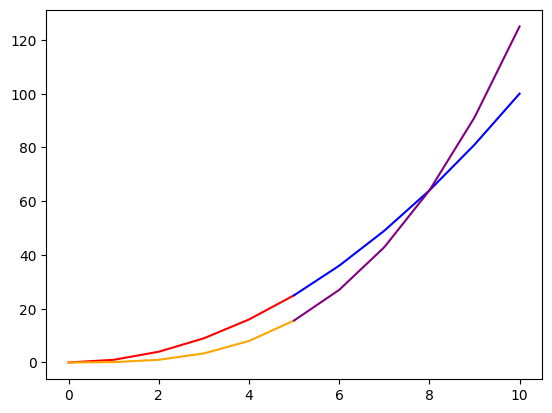

In [30]:
plt.plot(x_preds0, y_preds00, color='red')
plt.plot(x_preds1, y_preds10, color='blue')
plt.plot(x_preds0, y_preds01, color='orange')
plt.plot(x_preds1, y_preds11, color='purple')

In [31]:
func = interp1d([1,2,3], [1,4,9], bounds_error=False, fill_value='extrapolate')
func([1.5, 2.5])

array([2.5, 6.5])

In [32]:
a = [1,2]
b = 3
c = []
d = [4,5]
a.append(b)
print(a)
a.append(c)
print(a)
a.append(d)
print(a)


[1, 2, 3]
[1, 2, 3, []]
[1, 2, 3, [], [4, 5]]


In [33]:
from typing import Literal, Union

class Dummy(BaseModel):
    a: Union[Literal[False], Literal['a']]


b = Dummy(a=0)

In [13]:
from asoh.models.base import *
import numpy as np

class Dummy(HealthVariable, 
            arbitrary_types_allowed=True,
            validate_assignment=True):
    a: Union[float, List]
    b: Union[float, List]
    c: Union[float, List]

test = Dummy(base_values=[1,2,3],
             a = [4,5,6],
             b = 7,
             c = [8,9],
             updatable=('a', 'b', 'c') # ('base_values','a', 'b', 'c') # ('b',) # 
             )
print(test.updatable_len)
print(test.get_updatable_parameter_values())
test.c.append(10)
print(test.updatable_len)
print(test.get_updatable_parameter_values())
test.update(new_values=[10,11,12, 7.5], parameters=('a','b'))
print(test.updatable_len)
print(test.get_updatable_parameter_values())

6
[4, 5, 6, 7.0, 8, 9]
7
[4, 5, 6, 7.0, 8, 9, 10]
7
[10, 11, 12, 7.5, 8, 9, 10]


In [19]:
class DumDummy(BaseModel):
    a: Union[float, List, np.ndarray] = Field(allow_mutation=True)
    b: str = Field(allow_mutation=False)
    class Config:
        arbitrary_types_allowed=True
        validate_assignment=True

    @validate_call(config=ConfigDict(arbitrary_types_allowed=True))
    def update(self, val: Union[float, List, np.ndarray]):
        self.a = val

test = DumDummy(a=np.array([2,3]), b='b')
print(test.a)
test.update(np.array([4,5]))
print(test.a)
# test.b = 'b'

[2 3]
[4 5]


In [9]:
a = np.array([1,2,3])
print(a.tolist())
b = a[:]
print(b)
print(np.array(b))

[1, 2, 3]
[1 2 3]
[1 2 3]


In [8]:
str(('a', 'b', 'cd'))

"('a', 'b', 'cd')"

In [7]:
b[1:2]

[np.int64(2)]

In [23]:
class Dummy(BaseModel, validate_assignment=True):
    a: float

    @property
    def a(self) -> float:
        return 0.5 * self._2a

    @a.setter
    def a(self, val: float) -> None:
        self._2a = 2 * val

test = Dummy(a = 5)
print(test.a)
test.a = 'a'

5.0


ValidationError: 1 validation error for Dummy
a
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/float_parsing

In [30]:
a = np.array([123,4, np.pi, 1+2j]) # '123'
import numbers
[isinstance(val, numbers.Number) for val in a]

[True, True, True, True]

In [2]:
from asoh.models.ecm import SeriesResistance

r0 = SeriesResistance(base_values=1, temperature_dependence_factor=1.0e-03)
r0.updatable += ('temperature_dependence_factor',)
# r0.interpolation_style = 3
r0.get_updatable_parameter_values()

[1.0, 0.001]

In [49]:
from typing import Any
from pydantic import Field, BaseModel
from pydantic.json_schema import SkipJsonSchema

class Parent(BaseModel):
    a: str = 'a'

class Child(Parent):
    a: SkipJsonSchema[str] = Field('a', exclude=True)
    b: str = 'b'
    c: str = Field('c') # , exclude=True) #

    def model_post_init(self, __context: Any) -> None:
        del self.model_fields['a']
        delattr(self, 'a')
        return super().model_post_init(__context)

parent = Parent()
print('Parent')
print(parent.model_fields.keys())
print('----------------------------')
child = Child()
print('Child')
print(child.model_fields.keys())
print(child.model_dump())
print(child.model_json_schema())
print(child.a)

Parent
dict_keys(['a'])
----------------------------
Child
dict_keys(['b', 'c'])
{'b': 'b', 'c': 'c'}
{'properties': {'b': {'default': 'b', 'title': 'B', 'type': 'string'}, 'c': {'default': 'c', 'title': 'C', 'type': 'string'}}, 'title': 'Child', 'type': 'object'}


AttributeError: 'Child' object has no attribute 'a'

In [26]:
child.model_config

{'extra': 'forbid'}

In [28]:
child.model_fields

{'b': FieldInfo(annotation=str, required=False, default='b'),
 'c': FieldInfo(annotation=str, required=False, default='c', exclude=True)}

In [45]:
from pydantic.version import version_info as pydantic_v_info
print(pydantic_v_info())


             pydantic version: 2.7.4
        pydantic-core version: 2.18.4
          pydantic-core build: profile=release pgo=false
                 install path: /Users/vventuri/python_envs/ASOH_Diagnostics/lib/python3.9/site-packages/pydantic
               python version: 3.9.6 (default, Feb  3 2024, 15:58:27)  [Clang 15.0.0 (clang-1500.3.9.4)]
                     platform: macOS-14.5-arm64-arm-64bit
             related packages: typing_extensions-4.12.2
                       commit: unknown


In [7]:
class FakeList():
    def __init__(self, a):
        self.a = a

    def __len__(self):
        return self.a
    
    def __add__(self, value):
        return value + self.a
    
test = FakeList(5)
print(len(test))
print(test + 2)
test.a

5
7


5